# Système d'alerte pour les tempêtes

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectFromModel

## Préparation des Données

### importation de la base de donnée

In [14]:
DataFrame = pd.read_csv("Data_Arbre.csv")
print(DataFrame.head())

   longitude   latitude              clc_quartier             clc_secteur  \
0   3.293264  49.840500  Quartier du Centre-Ville             Quai Gayant   
1   3.273380  49.861409    Quartier du Vermandois              Stade Cepy   
2   3.289068  49.844513  Quartier du Centre-Ville   Rue Villebois Mareuil   
3   3.302387  49.861778      Quartier de l'Europe  Square des Marronniers   
4   3.304047  49.858446      Quartier de l'Europe           Avenue Buffon   

   haut_tot  haut_tronc  tronc_diam fk_arb_etat fk_stadedev     fk_port  \
0       6.0         2.0        37.0    EN PLACE       Jeune  semi libre   
1      13.0         1.0       160.0    EN PLACE      Adulte  semi libre   
2      12.0         3.0       116.0    REMPLACÉ      Adulte  semi libre   
3      16.0         3.0       150.0    EN PLACE      Adulte  semi libre   
4       5.0         2.0       170.0    Essouché      Adulte      réduit   

  fk_pied fk_situation fk_revetement  age_estim  fk_prec_estim  clc_nbr_diag  \
0   ga

### Sélection des colonnes pertinentes de la base de données afin de prédire la position des arbres susceptibles d'être déracinés en cas de tempête

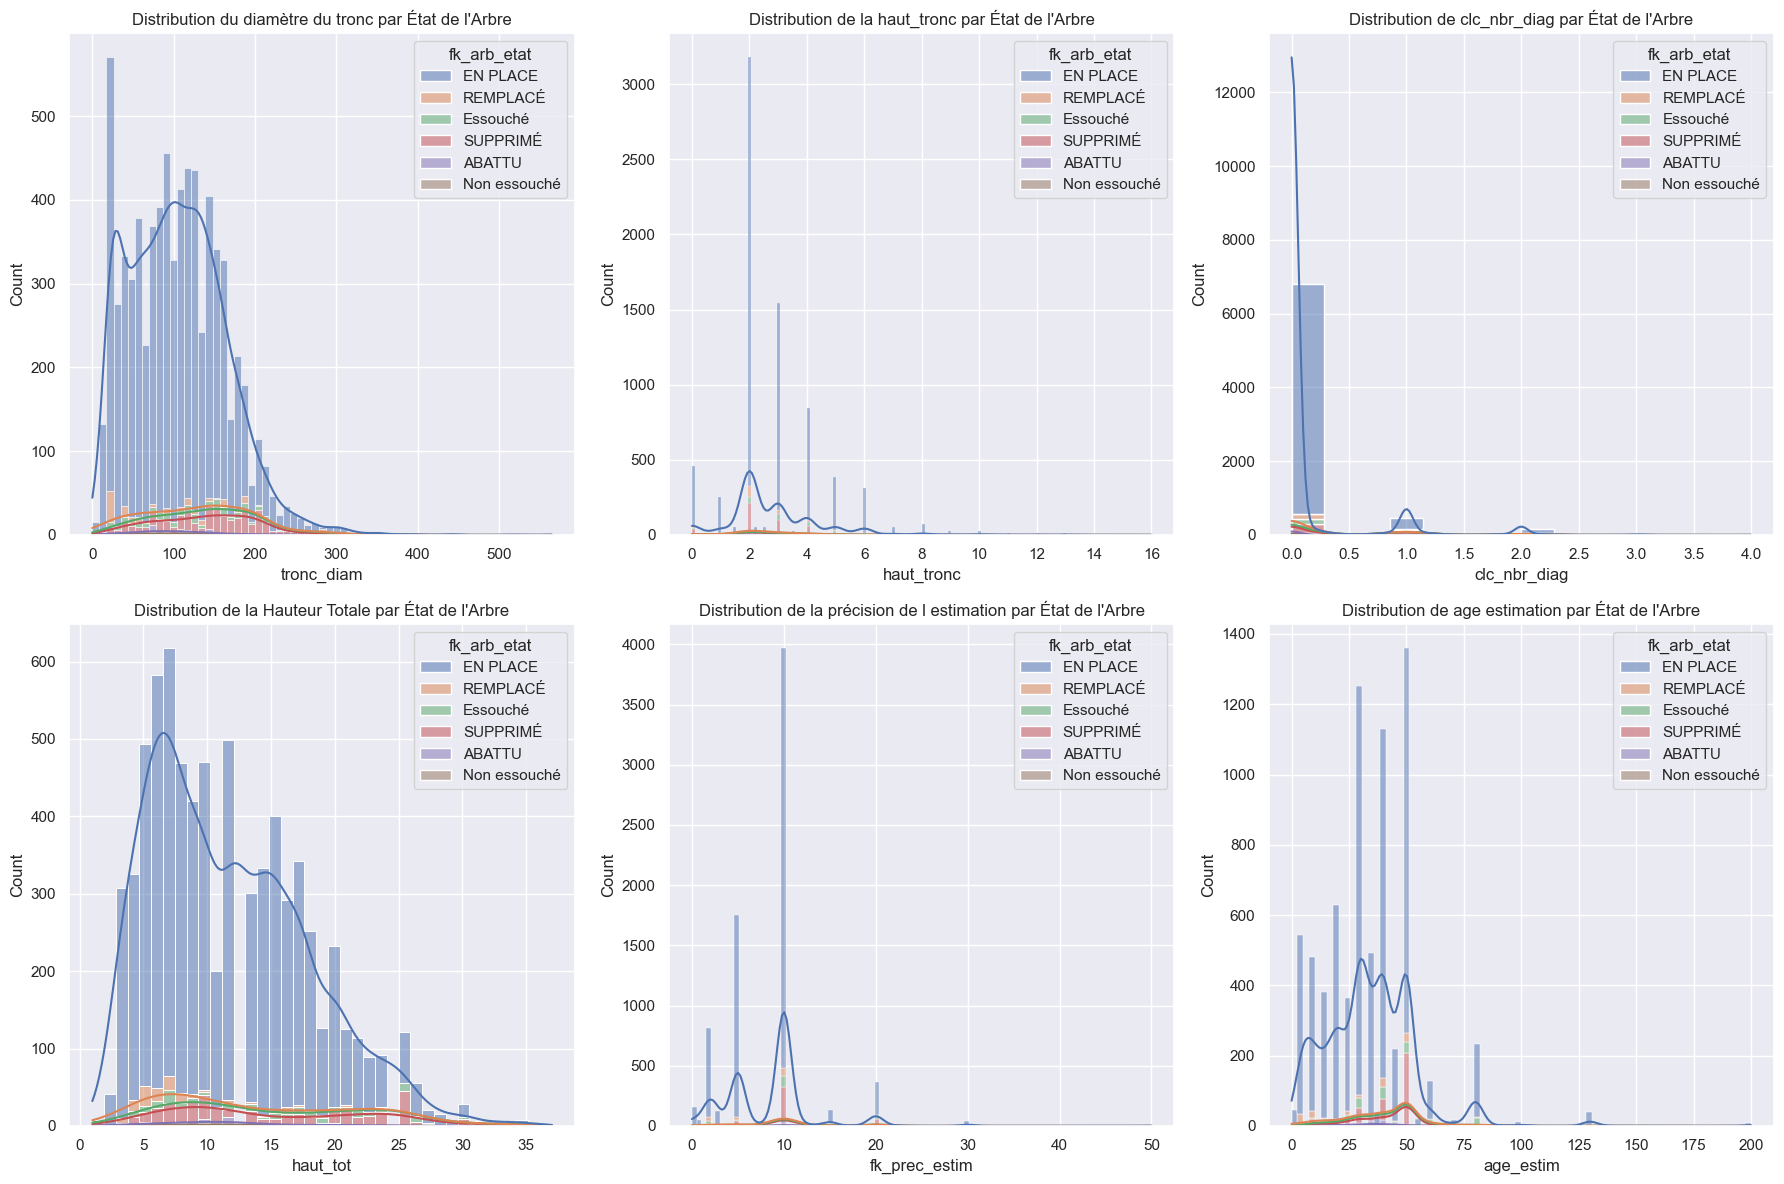

relation entre fk_arb_etat et fk_stadedev
p_valeur : 2.0070380148437296e-197 

relation entre fk_arb_etat et fk_port
p_valeur : 4.300627966507959e-64 

relation entre fk_arb_etat et fk_pied
p_valeur : 7.65017470523518e-65 

relation entre fk_arb_etat et fk_situation
p_valeur : 6.068948030872689e-22 

relation entre fk_arb_etat et fk_revetement
p_valeur : 0.17053897060126375 

relation entre fk_arb_etat et feuillage
p_valeur : 0.00016877493727947317 

relation entre fk_arb_etat et remarquable
p_valeur : 0.28681079545361776 



In [34]:
#l'encodage de nos données a déjà été effectué dans le fichier "Data_Arbre.csv".
#comment choisir les colonnes pertinentes pour la prédiction de la position des arbres susceptibles d'être déracinés en cas de tempête ?
# les différentes colonnes sont les suivantes : longitude, latitude, clc_quartier, clc_secteur, haut_tot, haut_tronc, tronc_diam, fk_arb_etat, fk_stadedev, fk_port, fk_pied, fk_situation, fk_revetement, age_estim, fk_prec_estim, clc_nbr_diag, fk_nomtech, villeca, feuillage, remarquable

#au début j'ai effectué une matrice de corrlation mais je me suis vite rendu compte que cela n'était pas pertinent pour ce type de données
# j'opte donc pour une méthode différente : les histplot
# conseillé par notre cher ami elouan
# https://seaborn.pydata.org/generated/seaborn.histplot.html
#on aurait egalement pu utiliser displot ou même des boxplots et en fonction de la médiane déterminer si la colonne est pertinente ou non
#https://seaborn.pydata.org/generated/seaborn.displot.html
#l'utilisation d'axe permet de tracer plusieurs graphiques sur une seule figure
#https://stackoverflow.com/questions/63895392/seaborn-is-not-plotting-within-defined-subplots
#un peu comme ce que l'on a fait dans le projet de math


# Sélectionner les colonnes pertinentes
colonnes_pertinentes = ['fk_prec_estim', 'haut_tronc', 'haut_tot', 'tronc_diam', 'fk_arb_etat', 'age_estim', 'clc_nbr_diag']
data_pertinent = DataFrame[colonnes_pertinentes]

# Tracer des histogrammes pour les variables numériques en fonction de fk_arb_etat
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
#multiple='stack' permet de superposer les histogrammes
#kde=True permet de tracer la densité de probabilité
#voir la documentation pour plus d'informations
sns.histplot(data=data_pertinent, x='tronc_diam', hue='fk_arb_etat', multiple='stack', ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution du diamètre du tronc par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='haut_tronc', hue='fk_arb_etat', multiple='stack', ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution de la haut_tronc par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='haut_tot', hue='fk_arb_etat', multiple='stack', ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution de la Hauteur Totale par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='fk_prec_estim', hue='fk_arb_etat', multiple='stack', ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution de la précision de l estimation par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='clc_nbr_diag', hue='fk_arb_etat', multiple='stack', ax=axes[0, 2], kde=True)
axes[0, 2].set_title('Distribution de clc_nbr_diag par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='age_estim', hue='fk_arb_etat', multiple='stack', ax=axes[1, 2], kde=True)
axes[1, 2].set_title('Distribution de age estimation par État de l\'Arbre')

plt.tight_layout()
plt.show()

#pour les variables qualitatives, on va  effectuer le test de chi2 pour voir si elles sont pertinentes pour la prédiction de la position des arbres susceptibles d'être déracinés en cas de tempête
#https://datascientest.com/correlation-entre-variables-comment-mesurer-la-dependance
# Test de chi2 pour les variables qualitatives
table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_stadedev'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_stadedev')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_port'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_port')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_pied'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_pied')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_situation'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_situation')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_revetement'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_revetement')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['feuillage'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et feuillage')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['remarquable'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et remarquable')
print('p_valeur :', result[1],'\n')



In [40]:
# feature selection : on va choisir les colonnes pertinentes pour la prédiction de la position des arbres susceptibles d'être déracinés en cas de tempête
# pour ce qui est de l'encodage, utilisation de One Hot Encoding, comme ce que la professeure a fait nous a conseillé de faire
# One Hot Encoding = https://medium.com/@sii-lille/data-science-one-hot-encoding-c59e82b3f0e7  Le one-hot encoding convertit les variables catégorielles en vecteurs de zéros et de uns, mieux que ce que l'on a fait dans le TP1, si on aurait eu 0, 1, 2 on aurait crée une relation implicite entre les valeurs
#https://scikit-learn.org/stable/modules/feature_selection.html   use 1.13.4
#https://www.geeksforgeeks.org/feature-selection-using-selectfrommodel-and-lassocv-in-scikit-learn/
#utilisation de la doc https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles pour la standardisation des données
#SelectFromModel : grâce à l'utilisation des scores d'importance des fonctionnalités d'un modèle pré-entraîné, la méthode de sélection des fonctionnalités scikit-learn SelectFromModel détermine automatiquement quelles fonctionnalités sont les plus importantes. Après la formation, seules les fonctionnalités qui répondent à un seuil de signification spécifié par l'utilisateur sont conservées par le modèle (soit arborescent, soit linéaire). En plus de maintenir, voire d'améliorer les performances de prédiction, cette stratégie simplifie les modèles en mettant l'accent sur les aspects les plus informatifs, en encourageant l'efficacité et en améliorant l'interprétabilité.


# Séparation des variables indépendantes et dépendantes 
#on ne prend pas en compte la colonne "fk_arb_etat" car c'est la colonne qu'on veut prédire
colonnes_numeriques = ['longitude', 'latitude', 'haut_tot', 'haut_tronc', 'tronc_diam', 'age_estim', 'fk_prec_estim']
colonnes_categorieles = ['clc_quartier', 'clc_secteur', 'fk_stadedev', 'fk_port', 'fk_pied', 'fk_situation', 'fk_revetement', 'feuillage', 'remarquable']

# Encodage des variables catégorielles
# Utilisons la méthode 'get_dummies' de pandas pour effectuer le one-hot encoding
# Concaténons les colonnes numériques avec les données 'countries' encodées en one-hot
#aller voir la doc pour plus d'informations très bien expliqué
X = pd.concat([DataFrame[colonnes_numeriques], pd.get_dummies(DataFrame[colonnes_categorieles])], axis=1)
y = DataFrame['fk_arb_etat']

# Standardisation des données
# on met nos données à la même échelle
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Affichage des données standardisées
# Conversion en DataFrame pour un affichage lisible
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Affichage des données standardisées
print(X_scaled_df.head())

# ou est mon fk_arb_etat ?
# bonne question
#et pourquoi ne pas avoir # Utilisons la méthode 'fit_transform' pour effectuer le one-hot encoding
#one_hot_encod = encoder.fit_transform(df[['countries']])



   longitude  latitude  haut_tot  haut_tronc  tronc_diam  age_estim  \
0  -0.121047 -1.027327 -0.920963    -0.46555   -1.148795  -0.968413   
1  -1.427386  0.976923  0.213100    -1.02441    0.934743   0.822235   
2  -0.396705 -0.642658  0.051091     0.09331    0.189412  -0.200993   
3   0.478338  1.012295  0.699128     0.09331    0.765349   0.822235   
4   0.587422  0.692942 -1.082973    -0.46555    1.104136   0.310621   

   fk_prec_estim  clc_quartier_HARLY  clc_quartier_OMISSY  \
0      -0.687534            -0.14521            -0.303792   
1       0.357548            -0.14521            -0.303792   
2       0.357548            -0.14521            -0.303792   
3      -1.314583            -0.14521            -0.303792   
4      -1.314583            -0.14521            -0.303792   

   clc_quartier_Quartier Remicourt  ...  fk_pied_gazon  \
0                        -0.498143  ...        0.74863   
1                        -0.498143  ...        0.74863   
2                        -0.4981

In [ ]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Entraînement du modèle de forêt aléatoire
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluation initiale
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Sélection des caractéristiques importantes
selector = SelectFromModel(clf, threshold='mean', prefit=True)
X_selected = selector.transform(X_scaled)

# Vérification des caractéristiques sélectionnées
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Entraînement du modèle sur les caractéristiques sélectionnées
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.3, random_state=42)
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train_sel)

# Évaluation du modèle avec les caractéristiques sélectionnées
y_pred_sel = clf_sel.predict(X_test_sel)
print("Classification Report with Selected Features:\n", classification_report(y_test_sel, y_pred_sel))
print("Accuracy with Selected Features:", accuracy_score(y_test_sel, y_pred_sel))

# Visualisation des caractéristiques importantes
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

| Variable      | Description                                    | Pertinence                                                                                         |
|---------------|------------------------------------------------|----------------------------------------------------------------------------------------------------|
| haut_tot      | Hauteur totale de l'arbre                      | Determine la position des arbres susceptible d'être déraciné à cause de leurs tailles              |
| tronc_diam    | Diamètre du tronc de l'arbre                   | Indique la robustesse de l'arbre, il peut être déraciné s'il a un petit diamètre                   |
| age_estim     | Estimation de l'âge de l'arbre                 | En fonction de l'âge, un arbre est plus ou moins susceptibles d'être déracinés en cas de tempête   |
